In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install holidays

In [3]:
pip install "flaml[automl]"


In [4]:
def HolidayFeatureCreator(input_data):
    """
    Receives as input a DataFrame or Series and creates a column named "Holidays_flag" with 1 if there is a holiday and with 0 if no holidays exist.
    Holidays derived from Germany.
    """
    if isinstance(input_data, pd.Series):
        input_df = pd.DataFrame(input_data)
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data
    else:
        raise ValueError("Input must be a DataFrame or Series.")

    assert isinstance(input_df.index, pd.DatetimeIndex), "Index must be a datetime index."

    national_holidays_all = holidays.US(years=[2014,2015,2016,2017,2018,2019,2020, 2021, 2022, 2023, 2024, 2025, 2026]).items()
    national_holidays = [items[0] for items in national_holidays_all]  # this is a list

    # Create a new column for holidays flag
    input_df["Holidays_flag"] = 0

    # Iterate over the index and set holiday flag to 1 if the date matches any national holiday
    for index_date in input_df.index:
        if index_date.date() in national_holidays:
            input_df.at[index_date, "Holidays_flag"] = 1

    return input_df

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import holidays
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# run before

In [6]:
FileName="original_df.csv"
Folder_Path="/content/gdrive/MyDrive/Encryption paper" #path of the folder
FilePath=os.path.join(Folder_Path,FileName)

In [7]:
df = pd.read_csv(FilePath, index_col=0,sep=",", parse_dates=[0], engine="pyarrow")


# Classification

In [8]:
df

,Total_load,T_LR,RH_LR,TotalOccupancy,HP_load
Timestamp,,,,,
2015-06-29 23:00:00,299.458779,22.563087,0.503126,1,323.767857
2015-06-29 23:15:00,466.724627,22.540183,0.501868,1,340.544933
2015-06-29 23:30:00,754.790855,22.517320,0.502705,1,47.819600
2015-06-29 23:45:00,659.912916,22.576871,0.511688,1,550.475400
2015-06-30 00:00:00,375.864625,22.467914,0.512145,1,95.565467
...,...,...,...,...,...
2016-01-31 22:45:00,519.532842,20.680876,0.384148,1,33.984267
2016-01-31 23:00:00,803.676897,20.653737,0.386150,1,33.580200
2016-01-31 23:15:00,533.693077,20.598383,0.388340,1,33.812333


In [9]:
df=df[["Total_load","T_LR","RH_LR","TotalOccupancy","HP_load"]]

In [10]:
df=HolidayFeatureCreator(df)
df["minute"]=df.index.minute
df["hour"]= df.index.hour
df["sin_hour"]= np.sin(df.index.hour*2*np.pi/24) #2πh/24 the hour 23 and 0 are close to one another but we want to have period function but sin of 23 and sin 0 are way apart one another
df["cos_hour"]= np.cos(df.index.hour*2*np.pi/24)
df["dayOfWeek"]=df.index.dayofweek
df["month"]=df.index.month
df.loc[df["dayOfWeek"]>4, "weekendFlag"]=1 #when day of the week is larger than 4 (5,6) put weekend flag to be 1
df.loc[df["dayOfWeek"]<5, "weekendFlag"]=0 #less that 5 is (4,3,2,1,0) 0 is work day, 1 is weekend
df.loc[:,"workingHour"]=0
df.loc[((df["hour"]>8) & (df["hour"]<19)), "workingHour"]=1

In [11]:


# Prepare the dataset
df['TotalOccupancy'] = df['TotalOccupancy'].astype(int)  # Ensure target column is integer
target = 'TotalOccupancy'
features = df.drop(columns=[target]).columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, shuffle=False,random_state=42
)

In [12]:
# Columns to add noise to
columns_to_add_noise = ['Total_load', 'T_LR', 'RH_LR', 'HP_load']
noise_std_fraction = 0.1  # 5% of standard deviation

# Add noise to each specified column
for col in columns_to_add_noise:
    std_dev = X_test[col].std()  # Compute the standard deviation of the column
    noise = np.random.normal(loc=0, scale=noise_std_fraction * std_dev, size=X_test[col].shape)
    X_test[col] = X_test[col] + noise

In [13]:
# FLAML AutoML setup
automl = AutoML()
settings = {
    "time_budget": 60,  # Total time in seconds for optimization
    "metric": "accuracy",  # Metric for evaluation
    "task": "classification",  # Task type
    "log_file_name": "flaml_classification.log",  # Log file name
    "split_type": "stratified",  # Use cross-validation
    "n_splits": 5,  # Number of folds for cross-validation
}

# Train the model
automl.fit(X_train=X_train, y_train=y_train, **settings)

# Evaluate the model
y_pred = automl.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

[flaml.automl.logger: 02-05 14:00:58] {1728} INFO - task = classification
[flaml.automl.logger: 02-05 14:00:58] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-05 14:00:58] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 02-05 14:00:58] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 02-05 14:00:58] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-05 14:00:58] {2393} INFO - Estimated sufficient time budget=1807s. Estimated necessary time budget=42s.
[flaml.automl.logger: 02-05 14:00:58] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.0747,	best estimator lgbm's best error=0.0747
[flaml.automl.logger: 02-05 14:00:58] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-05 14:00:58] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.0747,	best estimator lgbm's best error=0.0747
[flaml.automl.logger: 

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 02-05 14:00:59] {2442} INFO -  at 0.8s,	estimator sgd's best error=0.2727,	best estimator lgbm's best error=0.0349
[flaml.automl.logger: 02-05 14:00:59] {2258} INFO - iteration 5, current learner sgd
[flaml.automl.logger: 02-05 14:01:00] {2442} INFO -  at 1.6s,	estimator sgd's best error=0.2655,	best estimator lgbm's best error=0.0349
[flaml.automl.logger: 02-05 14:01:00] {2258} INFO - iteration 6, current learner xgboost
[flaml.automl.logger: 02-05 14:01:00] {2442} INFO -  at 2.2s,	estimator xgboost's best error=0.0747,	best estimator lgbm's best error=0.0349
[flaml.automl.logger: 02-05 14:01:00] {2258} INFO - iteration 7, current learner extra_tree
[flaml.automl.logger: 02-05 14:01:00] {2442} INFO -  at 2.4s,	estimator extra_tree's best error=0.0783,	best estimator lgbm's best error=0.0349
[flaml.automl.logger: 02-05 14:01:00] {2258} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 02-05 14:01:01] {2442} INFO -  at 2.5s,	estimator lgbm's best error

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 02-05 14:01:59] {2442} INFO -  at 60.6s,	estimator lrl1's best error=0.2661,	best estimator lgbm's best error=0.0000
[flaml.automl.logger: 02-05 14:01:59] {2685} INFO - retrain lgbm for 0.4s
[flaml.automl.logger: 02-05 14:01:59] {2688} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7330450035989674,
               learning_rate=0.3239297756196601, max_bin=511,
               min_child_samples=3, n_estimators=225, n_jobs=-1, num_leaves=4,
               reg_alpha=0.0009765625, reg_lambda=0.02411339190861214,
               verbose=-1)
[flaml.automl.logger: 02-05 14:01:59] {1985} INFO - fit succeeded
[flaml.automl.logger: 02-05 14:01:59] {1986} INFO - Time taken to find the best model: 31.05528950691223
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1095
           1       0.99      0.99      0.99      3053

    accuracy                           0.98      4148
   macro avg  

In [14]:
# Predict on the test set
y_pred = automl.predict(X_test)


In [15]:

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Calculate metrics for class 0
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

# Calculate metrics for class 1
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

# Calculate metrics overall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='binary')  # Use 'binary' for binary classification
f1 = f1_score(y_test, y_pred, average='binary')  # Use 'binary' for binary classification
print("Overall Metrics:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-Score:", f1)

# Print the metrics
print("Metrics for Class 0:")
print("Precision (Class 0):", precision_0)
print("Recall (Class 0):", recall_0)
print("F1-Score (Class 0):", f1_0)

print("\nMetrics for Class 1:")
print("Precision (Class 1):", precision_1)
print("Recall (Class 1):", recall_1)
print("F1-Score (Class 1):", f1_1)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1095
           1       0.99      0.99      0.99      3053

    accuracy                           0.98      4148
   macro avg       0.98      0.98      0.98      4148
weighted avg       0.98      0.98      0.98      4148

Confusion Matrix:
 [[1072   23]
 [  44 3009]]
Overall Metrics:
Accuracy: 0.983847637415622
Recall: 0.9855879462823453
F1-Score: 0.9889893179950698
Metrics for Class 0:
Precision (Class 0): 0.9605734767025089
Recall (Class 0): 0.9789954337899544
F1-Score (Class 0): 0.9696969696969697

Metrics for Class 1:
Precision (Class 1): 0.9924142480211082
Recall (Class 1): 0.9855879462823453
F1-Score (Class 1): 0.9889893179950698


In [16]:
metrics_data = {
    "Accuracy": [accuracy],
    "Recall (Overall)": [recall],
    "F1-Score (Overall)": [f1],
    "Precision (Class 0)": [precision_0],
    "Recall (Class 0)": [recall_0],
    "F1-Score (Class 0)": [f1_0],
    "Precision (Class 1)": [precision_1],
    "Recall (Class 1)": [recall_1],
    "F1-Score (Class 1)": [f1_1],
}

df_metrics = pd.DataFrame(metrics_data, index=["no encryption"])

In [17]:
df_metrics

,Accuracy,Recall (Overall),F1-Score (Overall),Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
no encryption,0.983848,0.985588,0.988989,0.960573,0.978995,0.969697,0.992414,0.985588,0.988989


In [18]:
FileNamemetrics="metrics.csv"
FilePath=os.path.join(Folder_Path,FileNamemetrics)
df_metrics.to_csv(FilePath, index=True)


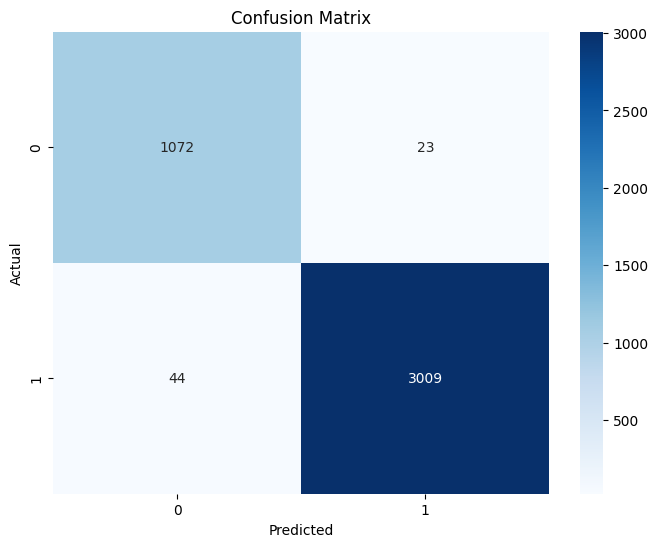

In [19]:


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=automl.classes_, yticklabels=automl.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importances:
Total_load: 69
T_LR: 39
RH_LR: 40
HP_load: 20
Holidays_flag: 0
minute: 37
hour: 75
sin_hour: 56
cos_hour: 101
dayOfWeek: 163
month: 46
weekendFlag: 6
workingHour: 23


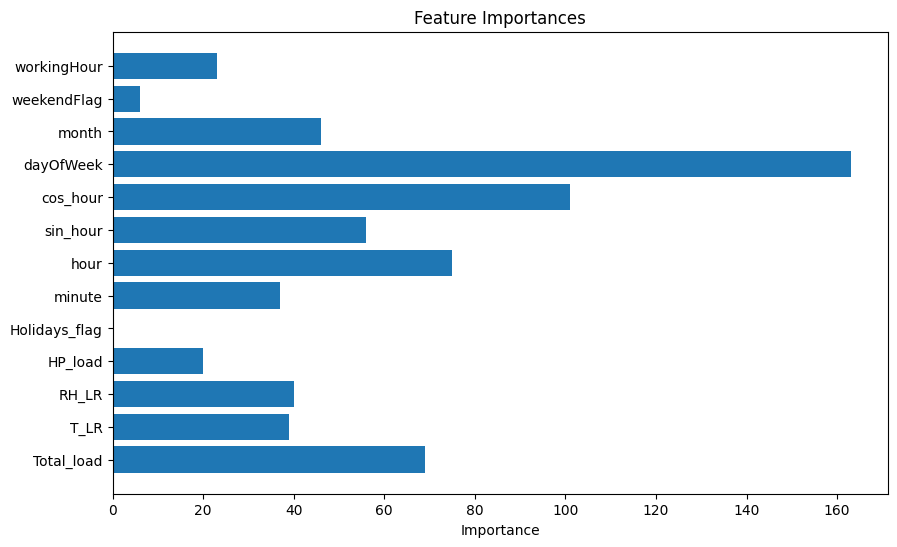

In [20]:
feature_importances = automl.feature_importances_
print("Feature Importances:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()